# Neural Ordinary Differential Equations

참고자료
+ paper : https://arxiv.org/abs/1806.07366
+ blog : https://seewoo5.tistory.com/12
+ youtube : https://www.youtube.com/watch?v=UegW1cIRee4&t=1594s


## Contributions
+ 특별한 backpropagation을 사용해 Memory의 절약을 이뤘다.
+ 기존의 반복적인 network들을 일반화하여 해석할 수 있다.

## forward method

ResNet의 경우를 살펴보면, residual connection이 반복되는 구조라고 생각 할 수 있다.

이 때, hidden state가 다음과 같이 residual block을 거치는 과정을 재귀적으로 표현할 수 있다.  
$h_{t+1} = h_t + f(h_t, \theta_t)$

<img src="https://drive.google.com/uc?id=1G2I-QjWxR2lOTQt2D0BsHlBAFxL_0yos" height=150>

이를 풀어서 쓰면, T번째 state는 다음과 같다.
$h_T = h_0 + f(h_0, \theta_0) + f(h_1, \theta_1) + ... + f(h_{T-1}, \theta_{T-1})$

해당 논문에선, 이러한 iterative한 update를 continuous한 변환과정의 Euler discretization으로 볼 수 있다고 설명한다.

<img src="https://drive.google.com/uc?id=1GyvJ6-J4DB1BFCTxHzDHmU91o2ebhbcw" height=200>  <img src="https://drive.google.com/uc?id=1pM1jlg-kS9U4kkV7-WrsQ7WC8_90Obo6" height=250>

그래서, 주어진 식을 continuous하게 바꿔주면, 다음과 같다.  
$\cfrac{d\mathbf{h}(t)}{dt} = f(\mathbf{h}(t), t, \theta)$

이 때의 f는, __해당 time step 다음(t+1)에 해당하는 layer를 생성해주는 함수__라고 볼 수 있다.
+ h(t) : t 시점에서의 hidden state
+ t와 $\theta$를 분리한 이유 : layer를 무한하게 만들 수 없기 때문.

<img src="https://drive.google.com/uc?id=1E68mk1NkSZhY946nY01dx7RyxmcbRxC8" height=400>

기존의 network는 이산적인 정해진 시간에 대해서만 state를 보낼 수 있었지만, ODE network를 사용하면 그 외의 경우에도 가능하다. 즉, 1.5층, 2.7층 layer도 실현가능하다는 의미.

## backward method

+ loss function : $L(\cdot)$ (scalar function)
+ hidden state : $z(\cdot)$ (vector)

$L(\mathbf{z}(t_1)) = L\bigg(\mathbf{z}(t_0) + \int_{t_0}^{t_1}{f(\mathbf{z}(t), t, \theta)dt} \bigg) = L(ODESolve(\mathbf{z}(t_0), f, t_0, t_1, \theta)$

다음과 같이 정의한다. 이 때, ODESolve가 존재한다고 가정.   
현재 시점과 state vector와 다음 시점을 입력받아, 함수에 집어넣어 그 다음 step까지의 편차를 계산하고 더한다는 의미.

<img src="https://drive.google.com/uc?id=1fYbB84p_WKh5OEhc35kQlf0sgchNhi-n" heigth="250">

### adjoint sensitivity method
모델을 optimize하기 위해서는 근본적으로, loss인 L에대한 파라미터 $\theta$의 미분을 구해야 하고 이는 각 $z, t, \theta$로 loss에 대한 미분 계산으로 이어진다.   
이에 대한 방법론을 제시한다.

$\mathbf{a}(t) := \cfrac{\partial{L}}{\partial{\mathbf{z}(t)}}$  
이 a를 adjoint라고 부르며, time step에서의 hidden state output으로 미분한 것을 의미한다.  
실제로 컴퓨터로 계산할때는 discrete하게 되므로, $t_i, t_{i+1}$step마다 dynamic하게 계산해주면 된다.

chain rule과 미분의 정의, taylor 전개를 이용해서 다음을 유도할 수 있다.  
$\cfrac{d\mathbf{a}(t)}{dt} = -\mathbf{a}(t)^T \frac{\partial f(\mathbf{z}(t), t, \theta)}{\partial \mathbf{z}}$

#### asm proof

<img src="https://drive.google.com/uc?id=1tbxf4OGuwzczWl9K8g6_fDN8AHoYR1_I" width=400>  
<img src="https://drive.google.com/uc?id=1SJAlkEeWUlfG54_3JSD1QXeRZNVPcixY" width=700>

####  

위의 식으로부터, $\theta$를 통한 미분값도 계산할 수 있다.

$\cfrac{dL}{d\theta} = -\int_{t_1}^{t_0} \mathbf{a}(t)^T \frac{\partial f(\mathbf{z}(t), t, \theta)}{\partial \mathbf{z}} dt$  


이렇게 미분값을 계산하게 되면장점이 무엇이냐, 바로 memory complexity 감소이다.  
원래의 Network들은 각 layer의 마다 미분값을 저장하고 갱신해줘야 한다.

하지만, 여기에서는 초기값 a(T)만 저장해놓으면, ODESolve 모듈에 집어넣어서 한번만 계산해주면 된다.

<img src="https://drive.google.com/uc?id=1HYLq42zjSGq7e1M6WnYLjcuUtYg09ZgL" height=150>

+ ResNet : 6개의 residual blocks을 사용.
+ RK-Net : Runge-Kutta integrator를 이용해 직접 backpropagation 계산
+ ODE-Net : ours

<img src="https://drive.google.com/uc?id=1x7SQ6Ip6Jwvs96d1e_lKKpMk13WYnslU" height=150>  
(출처 : https://www.youtube.com/watch?v=UegW1cIRee4&t=1594s)

## 코드
+ github : https://github.com/msurtsukov/neural-ode

### Neural ODE base 함수

In [ ]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()

In [ ]:
def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    # hidden state를 0.05초와 가깝도록 시간을 잘라서 계산함(0.046~0.05초). 그보다 작은 단위는 작은 단위로 한 번만 계산
    # ex) time list가 [0, 1, 1.5, 1.51, 2] 이러면, 0.05*20 / 0.05*10 / 0.01*1 / 0.049*10
    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    # solver function을 이용해 계산.
    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z

In [ ]:
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        # adjoint method. a * df/d(*)
        # a 를 grad_outputs로 두고, autograd.grad를 해주면, 곱해주는 효과가 난다.
        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

#### static method
class 를 사용할 때, 보통은 객체를 생성하여 성질을 넘겨받아서 사용하는데,
객체 없이 class에 바로 접근할 수 있다.  

class 안에 함수에 데코레이터를 활용하여 적용하고  
이를 사용하면 class에 독립적인 함수를 가시성 있게 사용할 수 있으며, 메모리의 장점도 가지고 있다.  
또한, 독립적이기 때문에, 상속받으면 해당 메소드는 그대로 유지된다.

In [ ]:
# static method

class test_class:
    def __init__(self):
        return print("instance made")

    @staticmethod
    def test_output(num1, num2):
        return num1 + num2

# staticmethod
print(test_class.test_output(1, 2)) # 3

# original way
cls_instance = test_class() # instance made
print(cls_instance.test_output(1, 2)) # 3

3
instance made
3


In [ ]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        # func : 학습하고자 하는 함수 f
        # staticmethod : 객체를 정의하지 않고 class에 직접 접근하는 방법

        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time


        # adjoint sensitivity method로 사용하기 위해 새롭게 정의한 solver 함수.
        # paper에서 말했듯이, 기울기를 저장하지 않고, time_step마다 삭제해준다.
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [ ]:
# apply method

@torch.no_grad()
def init_weights(m):
    print(m)
    if type(m) == nn.Linear:
        m.weight.fill_(1.0)
        print(m.weight)

net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
net.apply(init_weights)

Linear(in_features=2, out_features=2, bias=True)
Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
Linear(in_features=2, out_features=2, bias=True)
Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)


Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Linear(in_features=2, out_features=2, bias=True)
)

In [ ]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

### train utils

In [ ]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)

In [ ]:
# 맞추고자하는 target function
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(Tensor([[-0.1, -1.], [1., -0.1]]))

In [ ]:
# initialize할 training function
class RandomLinearODEF(LinearODEF):
    def __init__(self):
        super(RandomLinearODEF, self).__init__(torch.randn(2, 2)/2.)

In [ ]:
# 2*2 tensor로 되어있는 레이어를 통해, 새로운 manifold로 mapping해주는 layer.
# 구체적인 값은 밑의 forward를 통해 알 수 있다.
# 둘이 값을 각각 매기고, 빼준다. (trajectory생성하기 위함.(t번째랑 t-1번째 값을 빼면, 그 사이의 간격 출력되는 것을 이용))
class TestODEF(ODEF):
    def __init__(self, A, B, x0):
        super(TestODEF, self).__init__()
        self.A = nn.Linear(2, 2, bias=False)
        self.A.weight = nn.Parameter(A)
        self.B = nn.Linear(2, 2, bias=False)
        self.B.weight = nn.Parameter(B)
        self.x0 = nn.Parameter(x0)

    def forward(self, x, t):
        xTx0 = torch.sum(x*self.x0, dim=1)
        dxdt = torch.sigmoid(xTx0) * self.A(x - self.x0) + torch.sigmoid(-xTx0) * self.B(x + self.x0)
        return dxdt

In [ ]:
# hidden dimension을 설정해놓고, 2 -> 16 -> 2 로 계산시켜서 출력시키도록 한다.
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant

        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2 = nn.Linear(hid_dim, hid_dim)
        self.lin3 = nn.Linear(hid_dim, in_dim)
        self.elu = nn.ELU(inplace=True)

    def forward(self, x, t):
        if not self.time_invariant:
            x = torch.cat((x, t), dim=-1)

        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out

In [ ]:
def to_np(x):
    return x.detach().cpu().numpy()

In [ ]:
def plot_trajectories(obs=None, times=None, trajs=None, save=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    if obs is not None:
        if times is None:
            times = [None] * len(obs)
        for o, t in zip(obs, times):
            o, t = to_np(o), to_np(t)
            for b_i in range(o.shape[1]):
                plt.scatter(o[:, b_i, 0], o[:, b_i, 1], c=t[:, b_i, 0], cmap=cm.plasma)

    if trajs is not None:
        for z in trajs:
            z = to_np(z)
            plt.plot(z[:, 0, 0], z[:, 0, 1], lw=1.5)
        if save is not None:
            plt.savefig(save)
    plt.show()

In [ ]:
def conduct_experiment(ode_true, ode_trained, n_steps, name, plot_freq=10):
    # Create data
    # hidden state의 initial 값
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    t_max = 6.29*5
    n_points = 200

    index_np = np.arange(0, n_points, 1, dtype=np.int)
    index_np = np.hstack([index_np[:, None]])
    times_np = np.linspace(0, t_max, num=n_points)
    times_np = np.hstack([times_np[:, None]])

    times = torch.from_numpy(times_np[:, :, None]).to(z0)
    obs = ode_true(z0, times, return_whole_sequence=True).detach()
    obs = obs + torch.randn_like(obs) * 0.01

    # Get trajectory of random timespan
    min_delta_time = 1.0
    max_delta_time = 5.0
    max_points_num = 32
    def create_batch():
        t0 = np.random.uniform(0, t_max - max_delta_time)
        t1 = t0 + np.random.uniform(min_delta_time, max_delta_time)

        idx = sorted(np.random.permutation(index_np[(times_np > t0) & (times_np < t1)])[:max_points_num])

        obs_ = obs[idx]
        ts_ = times[idx]
        return obs_, ts_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_ = create_batch()

        z_ = ode_trained(obs_[0], ts_, return_whole_sequence=True)
        loss = F.mse_loss(z_, obs_.detach())

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if i % plot_freq == 0:
            z_p = ode_trained(z0, times, return_whole_sequence=True)

            plot_trajectories(obs=[obs], times=[times], trajs=[z_p], save=f"./assets/imgs/{name}/{i}.png")
            clear_output(wait=True)

### application : concepts

In [ ]:
ode_true = NeuralODE(SpiralFunctionExample())
ode_trained = NeuralODE(RandomLinearODEF())

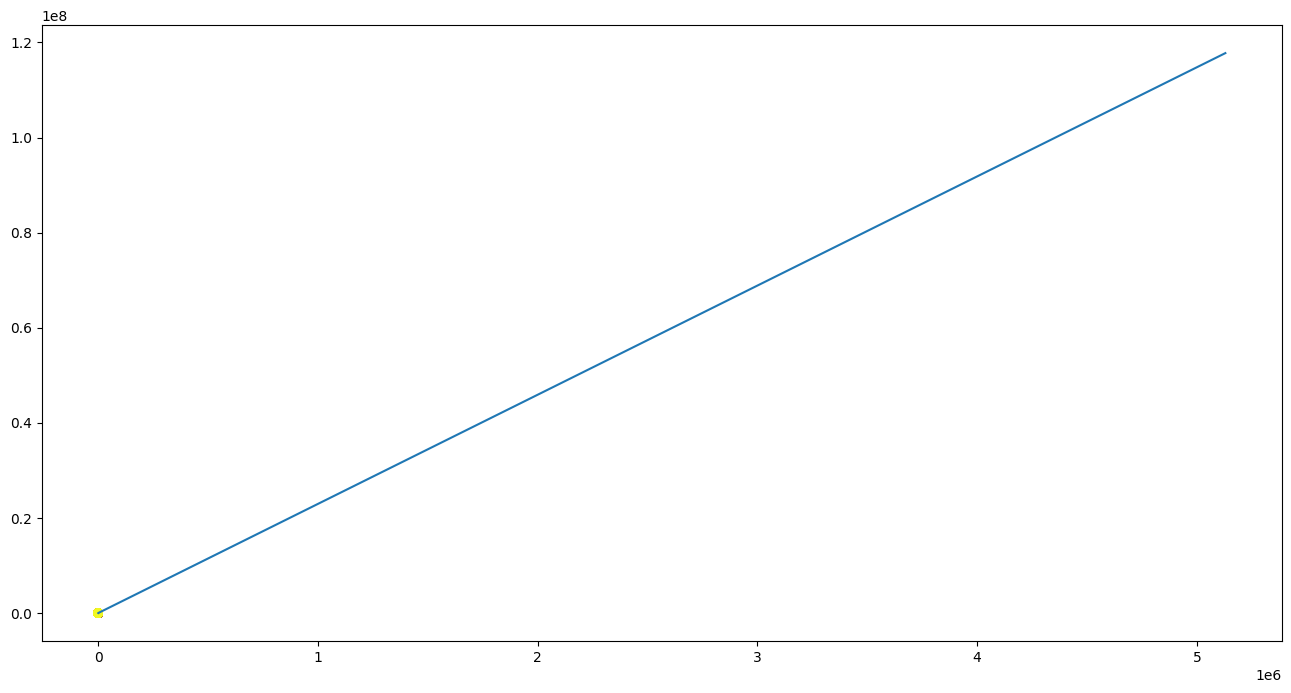

In [ ]:
conduct_experiment(ode_true, ode_trained, 500, "linear")

In [ ]:
func = TestODEF(Tensor([[-0.1, -0.5], [0.5, -0.1]]), Tensor([[0.2, 1.], [-1, 0.2]]), Tensor([[-1., 0.]]))
ode_true = NeuralODE(func)

func = NNODEF(2, 16, time_invariant=True)
ode_trained = NeuralODE(func)

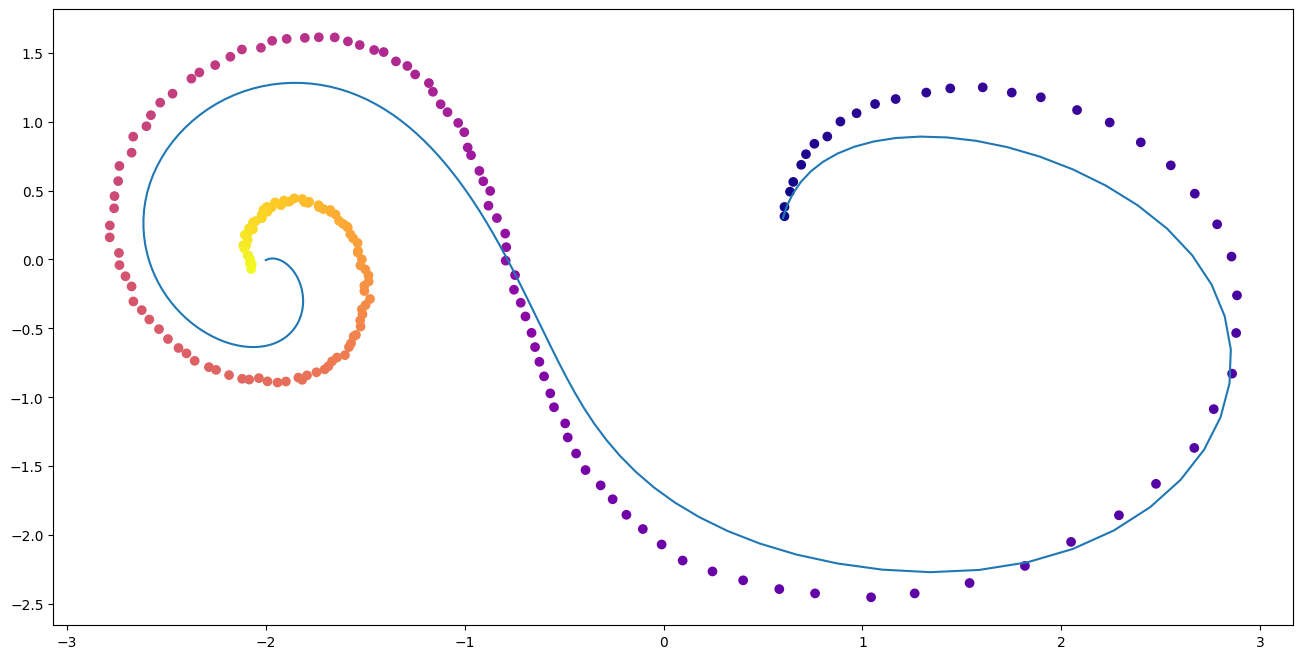

In [ ]:
conduct_experiment(ode_true, ode_trained, 3000, "comp", plot_freq=30)

### application : ResNet

In [ ]:
def norm(dim):
    return nn.BatchNorm2d(dim)

# 크기 안변하는 conv연산.
# receptive field만 상승한다.
def conv3x3(in_feats, out_feats, stride=1):
    return nn.Conv2d(in_feats, out_feats, kernel_size=3, stride=stride, padding=1, bias=False)

def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

In [ ]:
class ConvODEF(ODEF):
    def __init__(self, dim):
        super(ConvODEF, self).__init__()

        # 중간 feature dimension 1 줄여놓고 연산한다.(왜 늘리지 않고 줄이지)
        self.conv1 = conv3x3(dim + 1, dim)
        self.norm1 = norm(dim)
        self.conv2 = conv3x3(dim + 1, dim)
        self.norm2 = norm(dim)

    def forward(self, x, t):
        xt = add_time(x, t)
        h = self.norm1(torch.relu(self.conv1(xt)))
        ht = add_time(h, t)
        dxdt = self.norm2(torch.relu(self.conv2(ht)))
        return dxdt

In [ ]:
class ContinuousNeuralMNISTClassifier(nn.Module):
    def __init__(self, ode):
        super(ContinuousNeuralMNISTClassifier, self).__init__()
        self.downsampling = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
            norm(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 4, 2, 1),
        )
        self.feature = ode
        self.norm = norm(64)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64, 10)

    def forward(self, x):
        x = self.downsampling(x)
        x = self.feature(x)
        x = self.norm(x)
        x = self.avg_pool(x)
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        x = x.view(-1, shape)
        out = self.fc(x)
        return out

In [ ]:
func = ConvODEF(64)
ode = NeuralODE(func)
model = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model = model.cuda()

In [ ]:
func

ConvODEF(
  (conv1): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
ode

NeuralODE(
  (func): ConvODEF(
    (conv1): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [ ]:
model

ContinuousNeuralMNISTClassifier(
  (downsampling): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (feature): NeuralODE(
    (func): ConvODEF(
      (conv1): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [ ]:
import torchvision

img_std = 0.3081
img_mean = 0.1307


batch_size = 32
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(".data/mnist", train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(".data/mnist", train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize((img_mean,), (img_std,))
                             ])
    ),
    batch_size=128, shuffle=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 104652221.37it/s]


Extracting .data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to .data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 33352338.61it/s]


Extracting .data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to .data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28561776.33it/s]


Extracting .data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to .data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3722987.84it/s]


Extracting .data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to .data/mnist/MNIST/raw



In [ ]:
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def train(epoch):
    num_items = 0
    train_losses = []

    model.train()
    criterion = nn.CrossEntropyLoss()
    print(f"Training Epoch {epoch}...")
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        if use_cuda:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_losses += [loss.item()]
        num_items += data.shape[0]
    print('Train loss: {:.5f}'.format(np.mean(train_losses)))
    return train_losses

In [ ]:
def test():
    accuracy = 0.0
    num_items = 0

    model.eval()
    criterion = nn.CrossEntropyLoss()
    print(f"Testing...")
    with torch.no_grad():
        for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):
            if use_cuda:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            accuracy += torch.sum(torch.argmax(output, dim=1) == target).item()
            num_items += data.shape[0]
    accuracy = accuracy * 100 / num_items
    print("Test Accuracy: {:.3f}%".format(accuracy))

In [ ]:
n_epochs = 5
test()
train_losses = []
for epoch in range(1, n_epochs + 1):
    train_losses += train(epoch)
    test()

Testing...


<ipython-input-24-21ca1da03176>:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(test_loader),  total=len(test_loader)):


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 13.320%
Training Epoch 1...


<ipython-input-23-128259ae99dc>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.15641
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.370%
Training Epoch 2...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.04976
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.890%
Training Epoch 3...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.03789
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.450%
Training Epoch 4...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02935
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.860%
Training Epoch 5...


  0%|          | 0/1875 [00:00<?, ?it/s]

Train loss: 0.02512
Testing...


  0%|          | 0/79 [00:00<?, ?it/s]

Test Accuracy: 98.970%


<Axes: title={'center': 'train error'}, xlabel='cum_data'>

<Figure size 900x500 with 0 Axes>

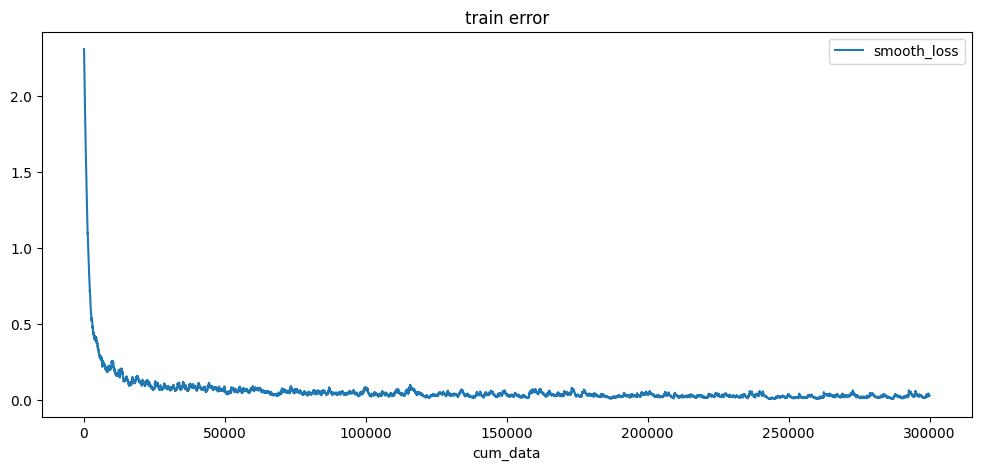

In [ ]:
import pandas as pd

plt.figure(figsize=(9, 5))
history = pd.DataFrame({"loss": train_losses})
history["cum_data"] = history.index * batch_size
history["smooth_loss"] = history.loss.ewm(halflife=10).mean()
history.plot(x="cum_data", y="smooth_loss", figsize=(12, 5), title="train error")

In [ ]:
func_r = ConvODEF(64)
ode_r = NeuralODE(func)
model_r = ContinuousNeuralMNISTClassifier(ode)
if use_cuda:
    model_r = model_r.cuda()